# Imports

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# Load Data

In [459]:
# Risk Free Rate
rf_rate = pd.read_csv('data/rf_data.csv', index_col=0, parse_dates=True)

In [384]:
rf_rate

,Date,Close
0,1995-01-03,7.877
1,1995-01-04,7.813
2,1995-01-05,7.868
3,1995-01-06,7.850
4,1995-01-09,7.882
...,...,...
7529,2024-12-23,4.599
7530,2024-12-24,4.591
7531,2024-12-26,4.579
7532,2024-12-27,4.619


In [50]:
# Models
log_reg_results = pd.read_pickle('models/log_reg_results.pkl')
rf_results = pd.read_pickle('models/rf_results.pkl')
svm_results = pd.read_pickle('models/svm_results.pkl')
xgb_results = pd.read_pickle('models/xgb_results.pkl')

In [337]:
# S&P 500 data
sp500_data = pd.read_csv('data/s&p500_data.csv', index_col = 0, parse_dates=True)
sp500_data['Daily Returns'] = sp500_data['Close'].pct_change()

In [157]:
indicators = pd.read_csv('data/indicators.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
indicators_w_polyterns = pd.read_csv('data/indicators_w_polyterms.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
Y_Matrix = pd.read_csv('data/Y_Matrix.csv', index_col=0, parse_dates=True)

# Apply Models

In [265]:
def fit_models(indicators, params):
    final = []
    for type, tenure in tqdm(params.items()):
        per_strategy = []
        for i in range(len(tenure)):
            model = tenure[i]
            current_year = str(2000 + i)
            current_indicators = indicators.loc[current_year]
            probabilities = model.predict_proba(current_indicators)
            per_strategy.append(
                pd.DataFrame(probabilities[: , 1], index=current_indicators.index, columns=[f'{type}'])
            )
        final.append(pd.concat(per_strategy, axis=0))

    return pd.concat(final, axis=1)

In [266]:
prob_log_reg = fit_models(indicators, log_reg_results)
prob_rf = fit_models(indicators, rf_results)
prob_xgb = fit_models(indicators, xgb_results)
prob_svm = fit_models(indicators, svm_results)


100%|██████████| 8/8 [00:00<00:00, 14.97it/s]


# Rescale Position from Probabilities

In [63]:
# Set seed for reproducibility
np.random.seed(42)

# Generate random probabilities
position = pd.DataFrame({
    'long': np.random.rand(1000),
    'short': np.random.rand(1000)
})

In [480]:
def compute_position(probabilities):
    position = probabilities.applymap(
        lambda x: max(1, (1/(1+np.exp(-20*(x-0.75))) - 1/(1+np.exp(5))) /
                         (1/(1+np.exp(-5)) - 1/(1+np.exp(5))) * 10) if x >= 0.5 else 0
    )
    return position.shift(1).dropna()

In [481]:
position_log_reg = compute_position(prob_log_reg)
position_rf = compute_position(prob_rf)
position_xgb = compute_position(prob_xgb)
position_svm = compute_position(prob_svm)

In [306]:
sp500_data

,Close,Daily Returns
Date,,
1995-01-03,459.109985,NaN
1995-01-04,460.709991,0.003485
1995-01-05,460.339996,-0.000803
1995-01-06,460.679993,0.000739
1995-01-09,460.829987,0.000326
...,...,...
2024-12-23,5974.069824,0.007287
2024-12-24,6040.040039,0.011043
2024-12-26,6037.589844,-0.000406


In [477]:
(position_svm > 0.5).mean()

long 3 days      0.014633
short 3 days     0.013838
long 5 days      0.049308
short 5 days     0.027835
long 8 days      0.099252
short 8 days     0.041037
long 10 days     0.157468
short 10 days    0.031653
dtype: float64

In [316]:
prova = position_log_reg.filter(like='3 days').resample('3B').first().reindex(sp500_data.index).ffill().dropna()

In [318]:
prova['short 3 days'] = prova['short 3 days'].apply(lambda x: -x)

In [332]:
prova['pos 3 days'] = np.where(
    prova['long 3 days'] > abs(prova['short 3 days']), prova['long 3 days'], prova['short 3 days']
)

<Axes: xlabel='Date'>

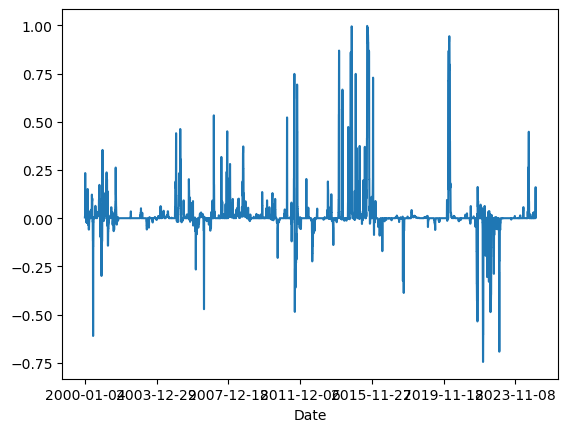

In [334]:
prova['pos 3 days'].plot()

In [326]:
returns = prova.apply(lambda x: sp500_data['Daily Returns'].reindex(prova.index).values * x)

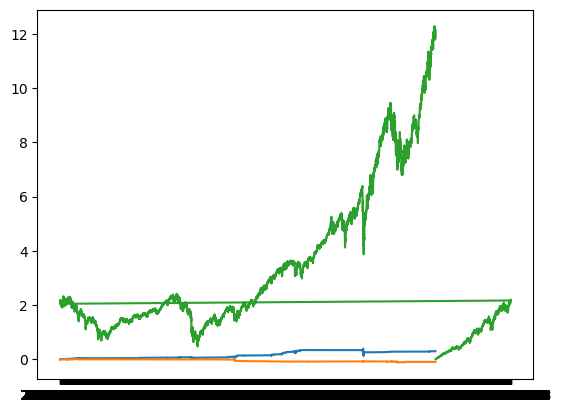

In [330]:
plt.plot((1 + returns).cumprod() - 1)
plt.plot((1 + sp500_data['Daily Returns']).cumprod() - 1)

# Backtest Strategy

In [482]:
def backtest_strategy(position, asset, rf_data, tc=0.0005):

    total_returns = pd.DataFrame(index=position.index)

    for n in (3, 5, 8, 10):
        # Resample and forward-fill positions
        current_position = position.filter(like=f'{n} days').resample(f'{n}B').first().reindex(asset.index).ffill().dropna()

        # Choose the larger position (comparing long vs. absolute value of short)
        current_position[f'pos {n} days'] = np.where(
            current_position[f'long {n} days'] > abs(current_position[f'short {n} days']),
            current_position[f'long {n} days'],
            current_position[f'short {n} days']
        )

        # Define risk-free position based on the absolute position taken
        current_position['risk free pos'] = 1 - np.abs(current_position[f'pos {n} days'])

        current_position['change in pos'] = np.abs(current_position[f'pos {n} days'].diff().fillna(0))

        # Calculate returns, aligning the indices properly.
        # Reindex asset returns and rf_rate to the index of current_position.
        aligned_asset_returns = asset['Daily Returns'].reindex(current_position.index)
        aligned_rf_data = rf_data['Close'].reindex(current_position.index)

        returns = current_position[f'pos {n} days'] * aligned_asset_returns.values + current_position['risk free pos'] * (aligned_rf_data.values/365/100) - tc * current_position['change in pos']

        # Store returns in a DataFrame with an appropriate column name
        returns_df = pd.DataFrame(returns, index=current_position.index, columns=[f'returns {n} days'])
        # Merge with total_returns on the index
        total_returns = pd.merge(total_returns, returns_df, left_index=True, right_index=True, how='outer')

    return total_returns

In [483]:
returns_log_reg = backtest_strategy(position_log_reg, sp500_data, rf_rate)
returns_rf = backtest_strategy(position_rf, sp500_data, rf_rate)
returns_xgb = backtest_strategy(position_xgb, sp500_data, rf_rate)
returns_svm = backtest_strategy(position_svm, sp500_data, rf_rate)

In [484]:
cum_returns_log_reg = (1 + returns_log_reg).cumprod(axis = 0) - 1
cum_returns_rf = (1 + returns_rf).cumprod(axis = 0) - 1
cum_returns_xgb = (1 + returns_xgb).cumprod(axis = 0) - 1
cum_returns_svm = ( 1 + returns_svm).cumprod(axis = 0) - 1

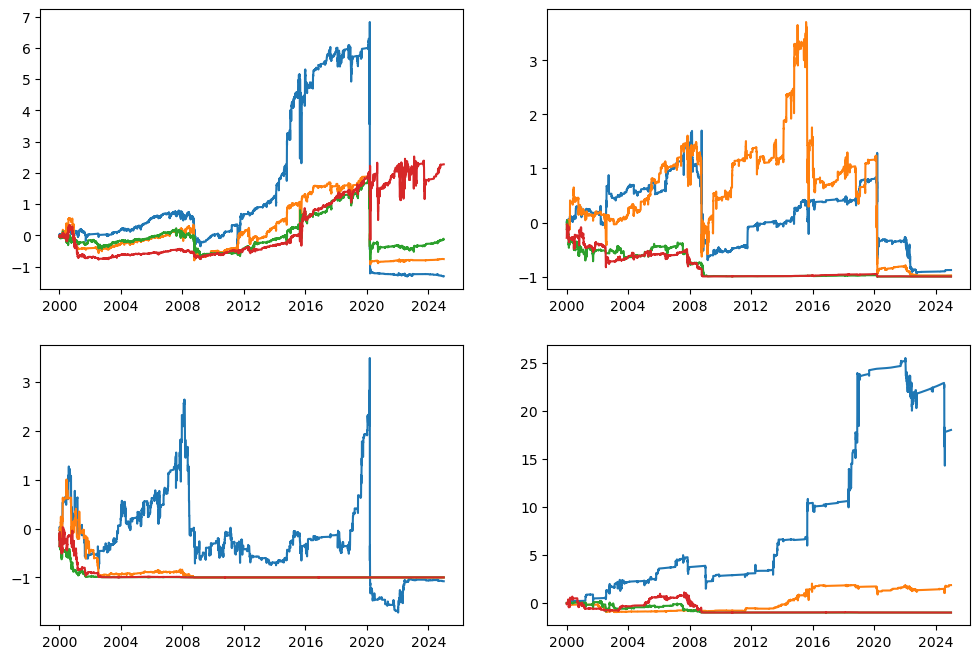

In [485]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))
ax[0, 0].plot(cum_returns_log_reg)
ax[0, 1].plot(cum_returns_rf)
ax[1, 0].plot(cum_returns_xgb)
ax[1, 1].plot(cum_returns_svm)

In [486]:
cum_returns_log_reg

,returns 3 days,returns 5 days,returns 8 days,returns 10 days
Date,,,,
2000-01-04,-0.038345,-0.038345,-0.061405,-0.039373
2000-01-05,-0.036496,-0.036496,-0.058623,-0.037482
2000-01-06,-0.035575,-0.035575,-0.057285,-0.036542
2000-01-07,0.024712,-0.009449,-0.016559,-0.009749
2000-01-10,0.051310,0.001635,0.000927,0.001622
...,...,...,...,...
2024-12-23,-1.307340,-0.751479,-0.113913,2.273705
2024-12-24,-1.312765,-0.748859,-0.104128,2.274117
2024-12-26,-1.312538,-0.748961,-0.104492,2.274528


In [451]:
(returns_log_reg > 0.08).mean()

returns 3 days     0.000159
returns 5 days     0.000000
returns 8 days     0.000000
returns 10 days    0.000159
dtype: float64

In [453]:
returns_log_reg

,returns 3 days,returns 5 days,returns 8 days,returns 10 days
Date,,,,
2000-01-04,0.017554,0.017302,0.008797,0.012006
2000-01-05,0.018018,0.017946,0.015497,0.016421
2000-01-06,0.017878,0.017802,0.015227,0.016198
2000-01-07,0.019874,0.017896,0.019301,0.018771
2000-01-10,0.016381,0.017911,0.016884,0.017271
...,...,...,...,...
2024-12-23,0.011747,0.012600,0.012513,0.012600
2024-12-24,0.012332,0.012574,0.012553,0.012578
2024-12-26,0.010466,0.012521,0.012334,0.012545


In [425]:
# For reproducibility
np.random.seed(42)

# 1. Simulate Daily Data
# Create a daily date range for 200 business days
dates = pd.date_range(start='2020-01-01', periods=200, freq='B')

# Simulate asset daily returns: mean ~0.0005, std ~0.01 (typical daily return & volatility)
asset_returns = np.random.normal(loc=0.0005, scale=0.01, size=len(dates))
asset = pd.DataFrame({'Daily Returns': asset_returns}, index=dates)

# Simulate a constant risk-free rate of 0.0001 per day
rf_rate = pd.Series(0.0001, index=dates)

# 2. Simulate Rebalancing Positions Data
# We rebalance every 3 days
rebalancing_dates = dates[::3]

# Generate positions:
# "long" weights between 0.4 and 0.6 and "short" weights between 0.0 and 0.2.
long_positions = np.random.uniform(0.4, 0.6, len(rebalancing_dates))
short_positions = np.random.uniform(0.0, 0.2, len(rebalancing_dates))

position = pd.DataFrame({
    'long': long_positions,
    'short': short_positions
}, index=rebalancing_dates)


            Daily Returns Strategy  Cumulative Returns
2020-01-01                0.003275            0.003275
2020-01-02               -0.000614            0.002659
2020-01-03                0.005100            0.007772
2020-01-06                0.008537            0.016375
2020-01-07               -0.000970            0.015389
2020-01-08               -0.000970            0.014405
2020-01-09                0.009181            0.023718
2020-01-10                0.004643            0.028471
2020-01-13               -0.002316            0.026089
2020-01-14                0.003287            0.029461


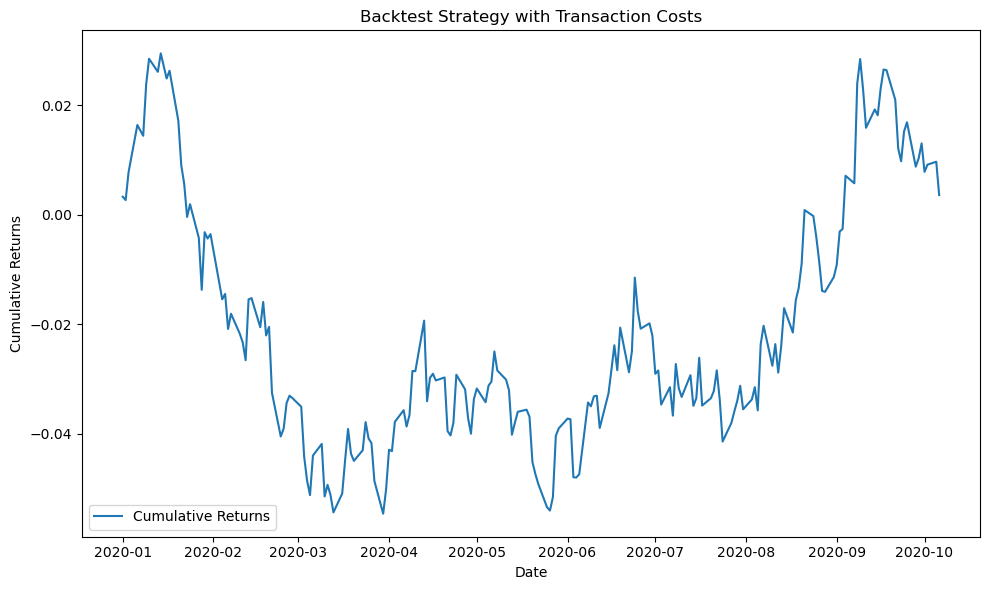

In [48]:
results = backtest_strategy(position, asset, rf_rate, tc=0.001)

# Display the first few rows of the results
print(results.head(10))

# Plot the cumulative returns over time
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Cumulative Returns'], label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Strategy with Transaction Costs')
plt.legend()
plt.tight_layout()
plt.show()

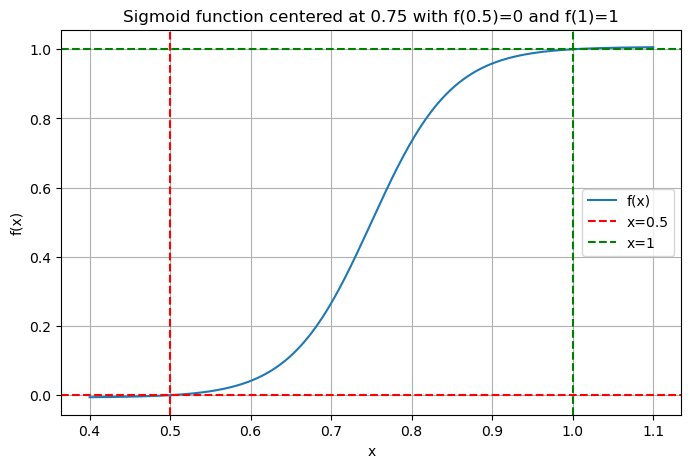

In [278]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return (1/(1+np.exp(-20*(x-0.75))) - 1/(1+np.exp(5))) / (1/(1+np.exp(-5)) - 1/(1+np.exp(5)))

# Generate x values
x_vals = np.linspace(0.4, 1.1, 500)
y_vals = f(x_vals)

# Create the plot
plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Sigmoid function centered at 0.75 with f(0.5)=0 and f(1)=1')
plt.axvline(x=0.5, color='red', linestyle='--', label='x=0.5')
plt.axvline(x=1.0, color='green', linestyle='--', label='x=1')
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=1, color='green', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()